In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

2024-04-14 15:18:02.797203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 15:18:02.986640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-04-14 15:18:02.986695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-14 15:18:03.028674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [2]:
model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/region_3_test_model_data_conif_vegc.csv')
unique_bins = sorted(model_data.stand_age_interval_min.unique())
bin_to_ordinal = {bin_val: idx for idx, bin_val in (enumerate(unique_bins))}
print(bin_to_ordinal)
model_data['ordinal_stand_age'] = model_data['stand_age_interval_min'].map(bin_to_ordinal)
model_data['ordinal_stand_age'].describe()


{0: 0, 5: 1, 10: 2, 15: 3, 20: 4, 25: 5, 30: 6, 35: 7, 40: 8, 45: 9, 50: 10, 55: 11, 60: 12, 65: 13, 70: 14, 75: 15, 80: 16, 85: 17, 90: 18, 95: 19, 100: 20, 125: 21, 150: 22}


count    287630.000000
mean          9.834551
std           7.873397
min           0.000000
25%           3.000000
50%           8.000000
75%          17.000000
max          22.000000
Name: ordinal_stand_age, dtype: float64

In [3]:
variables_to_compare = ['monthly_mean', 'tswrf_v11', 'tmp', 'precip', 'dtr', 'vpr', 'wind','co2','Ndep_Trendy']

base_comparison = model_data.loc[model_data['year'].between(1900,1950)].groupby(
    ['lon','lat','ordinal_stand_age'])[variables_to_compare].mean().reset_index()


model_data=model_data.merge(base_comparison, on = ['lon','lat','ordinal_stand_age'], suffixes = ('_ts', '_base'))
model_data=model_data.loc[model_data['monthly_mean_base']!=0]
# Iterate over the list of variables and create new columns in model_data for their ratios
for var in variables_to_compare:
    ts_column = f"{var}_ts"     # Time series data column name
    base_column = f"{var}_base" # Baseline data column name
    ratio_column = f"{var}_ratio" # Name for the new ratio column

    # Compute the ratio and create a new column in model_data
    model_data[ratio_column] = model_data[ts_column] / model_data[base_column]



In [4]:
model_data.monthly_mean_ratio.describe()
model_data[model_data.columns[model_data.columns.str.contains("ratio")]].describe()

,monthly_mean_ratio,tswrf_v11_ratio,tmp_ratio,precip_ratio,dtr_ratio,vpr_ratio,wind_ratio,co2_ratio,Ndep_Trendy_ratio
count,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000
mean,4.335098,0.999403,1.001299,1.010616,0.976701,1.004764,0.946794,1.053329,1.526560
std,171.280570,0.022604,0.039245,0.179026,0.088448,0.043000,0.096384,0.116367,0.935555
min,0.000000,0.898982,0.728632,0.317427,0.583784,0.838737,0.475303,0.891125,0.182726
25%,0.923263,0.986297,0.978221,0.885728,0.922215,0.982470,0.897918,0.973046,0.942539
50%,1.012550,0.998278,0.998002,1.002098,0.977612,0.999101,0.977253,1.015874,1.075442
75%,1.146784,1.011351,1.020492,1.122296,1.028145,1.020744,1.010705,1.122462,1.911993
max,35427.777778,1.120791,1.531550,3.241784,1.344187,1.446897,1.249307,1.396329,7.091084


In [5]:
len(model_data.loc[model_data['monthly_mean_ratio']>2 ])/len(model_data)

0.04390060555439549

In [6]:
model_data = model_data.loc[(model_data['year']>1950)&(model_data['monthly_mean_ratio']<2 )]

(array([ 4677.,   659.,   466.,   364.,   458.,   324.,   389.,   353.,
          409.,   505.,   521.,   615.,   755.,   900.,  1057.,  1365.,
         1815.,  2759.,  4660.,  8038., 10833., 10778., 10651.,  9745.,
         7532.,  5677.,  3776.,  2633.,  1754.,  1442.,  1042.,   859.,
          773.,   682.,   476.,   426.,   409.,   373.,   383.,   267.]),
 array([0.        , 0.04998763, 0.09997526, 0.14996289, 0.19995052,
        0.24993815, 0.29992578, 0.34991341, 0.39990104, 0.44988867,
        0.4998763 , 0.54986393, 0.59985156, 0.64983919, 0.69982682,
        0.74981445, 0.79980208, 0.84978971, 0.89977734, 0.94976497,
        0.9997526 , 1.04974023, 1.09972786, 1.14971549, 1.19970312,
        1.24969075, 1.29967838, 1.34966601, 1.39965364, 1.44964127,
        1.4996289 , 1.54961653, 1.59960416, 1.64959179, 1.69957941,
        1.74956704, 1.79955467, 1.8495423 , 1.89952993, 1.94951756,
        1.99950519]),
 <BarContainer object of 40 artists>)

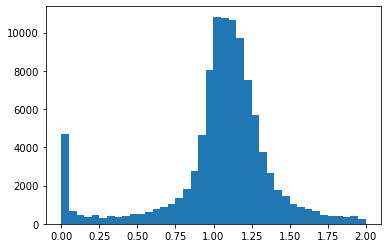

In [7]:
# model_data = model_data.loc[model_data['monthly_mean_ratio']<10]

plt.hist(model_data.monthly_mean_ratio, bins=40)

In [14]:
corr = model_data[model_data.columns[model_data.columns.str.contains('ratio')==True]].corr()


<Axes: >

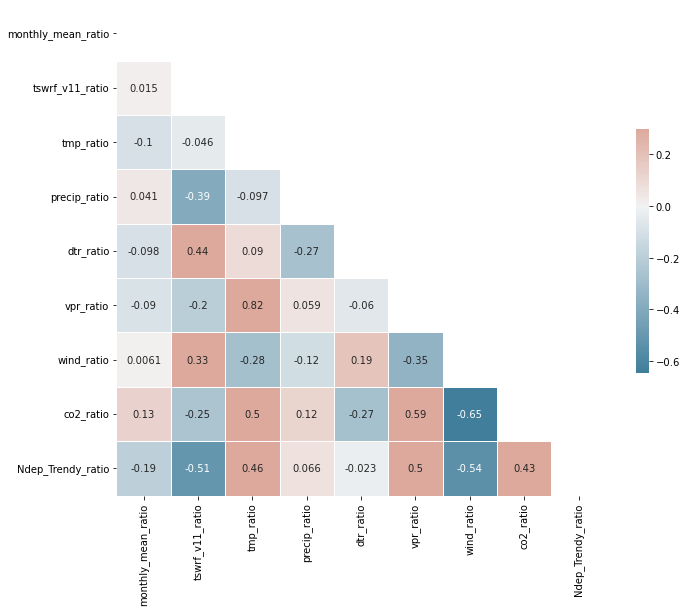

In [48]:
# Generate a large random dataset
# Compute the correlation matrix
corr = model_data[model_data.columns[model_data.columns.str.contains('ratio')==True]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [49]:
model_data.columns[model_data.columns.str.contains('ratio')==True]

Index(['monthly_mean_ratio', 'tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio',
       'Ndep_Trendy_ratio'],
      dtype='object')

In [50]:
len(model_data)

101600

In [8]:
####define training and testing set
# Define the features and target variable
X = model_data[['tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio', 'ordinal_stand_age']]
Y = (model_data['monthly_mean_ratio'])
# Y = np.sqrt(model_data['monthly_mean_ratio'])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)



In [60]:
regr = RandomForestRegressor(max_depth=40, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.5524236646191099

In [9]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)



In [64]:
svr_rbf.fit(X_train, y_train)
svr_rbf.score(X_test, y_test)

0.25275893460436716

In [ ]:
svr_lin.fit(X_train, y_train)
svr_lin.score(X_test, y_test)

In [ ]:
svr_poly.fit(X_train, y_train)
svr_poly.score(X_test, y_test)